# Grafo do mapa de agentes

In [ ]:
!pip install pyvis
!pip install igraph
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install chart_studio

In [ ]:
import os
import statistics
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pyvis import network as net
import igraph as ig
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot
from matplotlib import font_manager as fm
from matplotlib import rcParams

In [ ]:
# Definições gerais
outdir = './grafos'

In [ ]:
%%capture
!wget https://github.com/google/fonts/raw/main/ofl/firasans/FiraSans-Regular.ttf
!wget https://github.com/google/fonts/raw/main/ofl/firasans/FiraSans-Bold.ttf
!wget https://github.com/google/fonts/raw/main/ofl/firasans/FiraSans-Medium.ttf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

if not os.getcwd().endswith('Mapa agentes'):
    os.chdir('<<caminho para pasta raiz no drive>>')

# Import fonts
font_files = fm.findSystemFonts('.')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

Mounted at /content/drive


In [ ]:
main_font = 'Fira Sans'

new_rc_params = {'font.family': main_font,}
plt.rcParams.update(new_rc_params)

In [ ]:
# Planilha do google sheets
sheet_id = '<<id da planilha do Google Sheets usado para o mapa de agentes>>'

## Estilos

In [ ]:
# Leitura dos estilos
sheet_name = 'estilos'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df_estilo = pd.read_csv(url)
df_estilo = df_estilo[[i for i in df_estilo.columns if not i.startswith('Unnamed:')]]
df_estilo = df_estilo.rename(columns={'cor_preenchimento':'face', 'cor_borda':'border', 'espessura_borda':'edgewidth', 'cor_fonte':'label'}).fillna('').set_index('tag')
df_estilo = df_estilo.dropna(subset='descricao')
color_by_tags = df_estilo.to_dict(orient='index')
shape_by_tags = {i['tag']:i['forma'] for i in df_estilo.reset_index()[['tag','forma']].to_dict(orient='records')}
legend_items = [mlines.Line2D([], [],
                    color=m['face'],
                    marker=m['forma'],
                    linestyle='None',
                    markersize=10,
                    label=m['descricao'])\
                for m in color_by_tags.values()]

In [ ]:
# Função para formatar um texto com quebras de linha conforme um tamanho limite
def break_text(texto, limite=12, breaker='\n'):
    if not isinstance(texto, str):
        texto = str(texto)
    line = ''
    texto_out = ''
    for i in texto.split(' '):
        if i.strip() == '':
            continue
        if len(line) + len(i) > limite:
            texto_out += (line+breaker)
            line = i
        else:
            line = ' '.join([line, i])
    if line:
        texto_out += line
    return texto_out.strip()

In [ ]:
BASECOLOR = 'black'
CONTRASTCOLOR = 'white'
GRAYTONE = '#444444'
OVERLAY_EDGE_ALPHA = 1
BG_EDGE_ALPHA = 0.5
LINEBREAK = 15
ARROW_LW = 1.8
ARROW_SHRINK = 18

class grafo_agentes:
    def __init__(self, vinculos, agentes, foco=[]):
        self.grafo = nx.Graph()
        self.foco = foco
        self.vinculos = vinculos
        self.agentes = agentes

        # Adiciona as arestas
        for v in vinculos.to_dict(orient='records'):
            self.grafo.add_edge(v['card_1'],
                                v['card_2'],
                                data={'anotacao': v['anotacao'],
                                      'territorios': v['territorio'],
                                      'enfrentamento': v['enfrentamento'],
                                      'agente_atingido': v['agente_atingido']})

        # Calcula betweeness centrality do grafo
        scores = [i**2 for i in nx.betweenness_centrality(self.grafo).values()]
        bc_min = min(scores)
        bc_max = max(scores)
        bc_range = bc_max - bc_min
        scale_min = 0.5 #self.agentes['escala'].min()
        scale_max = 10 #self.agentes['escala'].max()
        scale_range = scale_max - scale_min
        bc_scores = [{'card':k, 'escala_bc':scale_min+((((v**2)-bc_min)/bc_range)*scale_range)} for k,v in nx.betweenness_centrality(self.grafo).items()]
        self.dic_bc_scores = {k:scale_min+((((v**2)-bc_min)/bc_range)*scale_range) for k,v in nx.betweenness_centrality(self.grafo).items()}
        self.median_bc = statistics.median(self.dic_bc_scores.values())
        self.agentes = self.agentes.merge(pd.DataFrame(bc_scores), on='card', how='left')

        # Preenche dados para agentes
        node_data = self.agentes.set_index('card').to_dict(orient='index')
        for k,v in node_data.items():
            v['tipo']='agente'
        nx.set_node_attributes(self.grafo, node_data)

        # Preenche dados para processos
        proc_data = {}
        for k in [i for i in self.grafo.nodes if i not in node_data]:
            proc_data[k] = {'tipo':'processo',
                            'escala':2,
                            'escala_bc':self.dic_bc_scores[k],
                            'tags':'proc'}
        nx.set_node_attributes(self.grafo, proc_data)

    def selecionar_nos(self, origin, search_dist=1, how='dict'):
        if isinstance(origin, str):
            origin = [origin]
        nodes = {0:origin}
        level = 0

        while level < search_dist:
            nodes[level+1] = []
            past_nodes = [i for j in nodes.values() for i in j]
            for n in nodes[level]:
                nodes_to_add = [i for i in dict(self.grafo[n]).keys() if i not in past_nodes]
                nodes[level+1] += nodes_to_add
            level += 1

        if how=='dict':
            return nodes
        elif how=='list':
            return [i for j in nodes.values() for i in j]
        else:
            raise Exception

    def subgrafo_do_no(self, ref_nodes=[], search_dist=1):
        if isinstance(ref_nodes, str):
            ref_nodes = [ref_nodes]
        if not ref_nodes: ref_nodes = self.foco
        list_of_nodes = self.selecionar_nos(ref_nodes, search_dist=search_dist, how='list')
        subgraph = self.grafo.subgraph(list_of_nodes)

        sub_agentes = self.agentes[self.agentes['card'].apply(lambda x: x in list_of_nodes)]
        sub_vinculos = self.vinculos[self.vinculos.apply(lambda x: x['card_1'] in list_of_nodes and x['card_2'] in list_of_nodes, axis=1)]

        return grafo_agentes(sub_vinculos, sub_agentes, foco=ref_nodes)

    def plot(self, title='', figsize=(25,18), savename='', savedir='', scale_by_bc=False):
        pos = nx.drawing.nx_agraph.graphviz_layout(self.grafo, prog='neato')
        #pos = nx.kamada_kawai_layout(self.grafo)
        fig = plt.figure(1, figsize=figsize, dpi=100, facecolor=BASECOLOR)
        fig.tight_layout()

        # Desenha as arestas
        for edge in self.grafo.edges():
            source, target = edge
            rad = 0.2
            con_style = f"arc3,rad={rad}"
            edgedata = self.grafo.get_edge_data(*edge)['data']

            t1 = self.grafo.nodes[target]['tipo']
            t2 = self.grafo.nodes[source]['tipo']
            if edgedata['agente_atingido'] and edgedata['enfrentamento']:
                p1 = '<'
                p2 = '>'
            elif edgedata['agente_atingido']:
                p1 = '' if t1 in ['processo'] else '<'
                p2 = '' if t2 in ['processo'] else '>'
            else:
                p1 = '<' if t1 in ['processo'] else ''
                p2 = '>' if t2 in ['processo'] else ''
            tag1 = self.grafo.nodes[target]['tags']
            tag2 = self.grafo.nodes[source]['tags']

            if tag1 == tag2:
                linecolor = color_by_tags[tag1]['face']
            elif t1 =='processo' and t2 !='processo':
                linecolor = color_by_tags[tag2]['face']
            elif t1 !='processo' and t2 =='processo':
                linecolor = color_by_tags[tag1]['face']
            else:
                linecolor = GRAYTONE

            arrowstyle = f'{p1}-{p2}'
            arrowprops=dict(lw=ARROW_LW,
                            arrowstyle=arrowstyle,
                            mutation_scale=10,
                            color=linecolor,
                            alpha=OVERLAY_EDGE_ALPHA,
                            connectionstyle=con_style,
                            linestyle= 'dotted' if edgedata['enfrentamento'] else '-',
                            shrinkA=ARROW_SHRINK,
                            shrinkB=ARROW_SHRINK)
            plt.annotate('',
                        xy=pos[source],
                        xytext=pos[target],
                        arrowprops=arrowprops,
                        zorder=2
                       )

        # Formato dos nós
        shape_by_tipo={'agente':'o', 'processo':'s'}

        # Estiliza os nós conforme o tipo (agente, processo)
        for tipo, shape in shape_by_tags.items():
            filtered_nodes = [i for i in filter(lambda x: x[1]['tags']==tipo, self.grafo.nodes(data=True))]

            # Escala
            if scale_by_bc:
                scale_nodes = [i[1]['escala_bc']*300 for i in filtered_nodes]
            else:
                scale_nodes = [i[1]['escala']*300 for i in filtered_nodes]
            scale_edges = [i[1]['escala']*3 for i in filtered_nodes]

            taglist = {i[0]:i[1]['tags'] for i in filtered_nodes}

            # Estilos definidos pelo nível
            color_nodes = [color_by_tags[v]['face'] for k,v in taglist.items()]
            #color_border = [color_by_tags[v]['face'] for  k,v in taglist.items()]
            color_border = [BASECOLOR for  k,v in taglist.items()]
            edge_width = [2 for k,v in taglist.items()]

            drawn_nodes = nx.draw_networkx_nodes(self.grafo, pos, node_shape=shape, nodelist=[i[0] for i in filtered_nodes], alpha=1, node_size=scale_nodes, node_color=color_nodes)
            drawn_nodes.set_edgecolor(color_border)
            drawn_nodes.set_linewidth(edge_width)
            drawn_nodes.set_zorder(1)

        # Estiliza os textos conforme o grupo
        for group in color_by_tags:
            filtered_labels = [i for i in filter(lambda x: x[1]['tags']==group, self.grafo.nodes(data=True))]
            color_label = color_by_tags[group]['label']

            formated_names = {i[0]:break_text(i[0], LINEBREAK) for i in filtered_labels}
            if scale_by_bc:
                formated_names = {k:(v if self.grafo.nodes(data=True)[k]['escala_bc'] >= self.median_bc else '') for k,v in formated_names.items()}
            drawn_labels = nx.draw_networkx_labels(self.grafo, pos, formated_names, font_size=10, font_family=main_font, font_weight='regular', font_color=color_label)
            #drawn_labels.set_zorder(15)

        #nx.draw_networkx_edge_labels(self.G, pos, {n: n for n in list(self.G.edges)}, font_size=6)
        plt.box(False)
        plt.legend(handles=legend_items,
                   fontsize=9,
                   borderpad=1,
                   framealpha=0,
                   labelspacing=0.75,
                   labelcolor=[i['label'] for i in color_by_tags.values()])

        if title:
            plt.title('  '+title, color=CONTRASTCOLOR, fontfamily=main_font, fontweight='medium', fontsize=25, loc='left', pad='-30')

        if savename:
            plt.savefig(savedir+'/'+savename+'.png', transparent=(BASECOLOR=='white'), bbox_inches='tight')
        plt.show()

    def plot_subgrafo(self, ref_nodes, search_dist=[1], title='', figsize=(25,18), savename='', savedir=''):
        pos = nx.drawing.nx_agraph.graphviz_layout(self.grafo, prog='neato')
        fig = plt.figure(1, figsize=figsize, dpi=100, facecolor=BASECOLOR)
        fig.tight_layout()

        # Recorta o subgrafo para plotagem
        if not isinstance(search_dist, list):
            search_dist = [search_dist]
        max_search_dist = max(search_dist)
        level_dict = self.selecionar_nos(ref_nodes, search_dist=max_search_dist, how='dict')
        subgrafo_agentes = self.subgrafo_do_no(ref_nodes, max_search_dist)
        subgrafo = subgrafo_agentes.grafo
        foco = subgrafo_agentes.foco

        # Cria categorias de nós
        curr_level = [i for j in search_dist for i in level_dict[j]]
        prev_levels = [i for j in level_dict.values() for i in j if i not in curr_level]
        post_levels = [i for i in list(self.grafo.nodes) if i not in list(subgrafo.nodes)]

        ### Plotagem
        # Desenha as arestas do subgrafo
        for edge in self.grafo.edges():
            source, target = edge
            rad = 0.2
            con_style = f"arc3,rad={rad}"
            edgedata = self.grafo.get_edge_data(*edge)['data']

            # Define variáveis para estilização
            t1 = self.grafo.nodes[target]['tipo']
            t2 = self.grafo.nodes[source]['tipo']
            if edgedata['agente_atingido'] and edgedata['enfrentamento']:
                p1 = '<'
                p2 = '>'
            elif edgedata['agente_atingido']:
                p1 = '' if t1 in ['processo'] else '<'
                p2 = '' if t2 in ['processo'] else '>'
            else:
                p1 = '<' if t1 in ['processo'] else ''
                p2 = '>' if t2 in ['processo'] else ''
            tag1 = self.grafo.nodes[target]['tags']
            tag2 = self.grafo.nodes[source]['tags']

            # Define cor da aresta
            if tag1 == tag2:
                linecolor = color_by_tags[tag1]['face']
            elif t1 =='processo' and t2 !='processo':
                linecolor = color_by_tags[tag2]['face']
            elif t1 !='processo' and t2 =='processo':
                linecolor = color_by_tags[tag1]['face']
            else:
                linecolor = GRAYTONE

            # Define visibilidade
            if edge in subgrafo.edges():
                alpha = OVERLAY_EDGE_ALPHA
            else:
                alpha = BG_EDGE_ALPHA

            arrowstyle = f'{p1}-{p2}'
            arrowprops=dict(lw=ARROW_LW,
                            arrowstyle=arrowstyle,
                            mutation_scale=10,
                            color=linecolor,
                            alpha=alpha,
                            connectionstyle=con_style,
                            linestyle= 'dotted' if edgedata['enfrentamento'] else '-',
                            shrinkA=ARROW_SHRINK,
                            shrinkB=ARROW_SHRINK)
            plt.annotate('',
                        xy=pos[source],
                        xytext=pos[target],
                        arrowprops=arrowprops,
                        zorder=3
                       )

        # Formato dos nós
        shape_by_tipo={'agente':'o', 'processo':'s'}

        # Estiliza os nós conforme o tipo (agente, processo)
        for tipo, shape in shape_by_tags.items():
            filtered_nodes = [i for i in filter(lambda x: x[1]['tags']==tipo, subgrafo.nodes(data=True))]

            # Escala dos nós
            scale_nodes = [i[1]['escala']*300 for i in filtered_nodes]
            scale_edges = [i[1]['escala']*3 for i in filtered_nodes]

            taglist = {i[0]:i[1]['tags'] for i in filtered_nodes}

            # Estilos definidos pelo nível
            color_nodes = [color_by_tags[v]['face'] for k,v in taglist.items()]#[BASECOLOR if k in curr_level else color_by_tags[v]['face'] for k,v in taglist.items()]
            color_border = [color_by_tags[v]['face'] if k in curr_level else BASECOLOR for  k,v in taglist.items()]
            edge_width = [color_by_tags[v]['edgewidth'] if k in curr_level else 0 for  k,v in taglist.items()]

            drawn_nodes = nx.draw_networkx_nodes(subgrafo, pos, node_shape=shape, nodelist=[i[0] for i in filtered_nodes], alpha=1, node_size=scale_nodes, node_color=color_nodes)
            drawn_nodes.set(joinstyle='miter')
            drawn_nodes.set_edgecolor(color_border)
            drawn_nodes.set_linewidth(edge_width)
            drawn_nodes.set_zorder(2)

            # Destaque no foco
            group_focus = [i for i in taglist if i in foco]
            if group_focus:
                color_focus_nodes = [BASECOLOR for i in group_focus]
                color_focus_border = [CONTRASTCOLOR for i in group_focus]
                focus_edge_width = [1 for i in group_focus]
                scale_focus_nodes = [i[1]['escala']*800 for i in filtered_nodes if i[0] in group_focus]
                focus_nodes = nx.draw_networkx_nodes(subgrafo, pos, node_shape=shape, nodelist=group_focus, alpha=1, node_size=scale_focus_nodes, node_color=color_focus_nodes)
                focus_nodes.set(joinstyle='miter')
                focus_nodes.set_edgecolor(color_focus_border)
                focus_nodes.set_linewidth(focus_edge_width)
                focus_nodes.set_zorder(1)

        # Desenha os nós posteriores
        for tipo, shape in shape_by_tags.items():
            filtered_nodes = [i for i in filter(lambda x: x[1]['tags']==tipo, self.grafo.nodes(data=True)) if i not in list(subgrafo.nodes)]

            # Escala dos nós
            scale_nodes = [i[1]['escala']*300 for i in filtered_nodes]
            scale_edges = [i[1]['escala']*3 for i in filtered_nodes]

            taglist = {i[0]:i[1]['tags'] for i in filtered_nodes}

            # Estilos definidos pelo nível
            color_nodes = [BASECOLOR if k in curr_level else color_by_tags[v]['face'] for k,v in taglist.items()]
            color_border = [color_by_tags[v]['face'] if k in curr_level else BASECOLOR for k,v in taglist.items()]
            edge_width = [color_by_tags[v]['edgewidth'] if k in curr_level else 0 for k,v in taglist.items()]

            drawn_nodes = nx.draw_networkx_nodes(subgrafo, pos, node_shape=shape, nodelist=[i[0] for i in filtered_nodes], alpha=BG_EDGE_ALPHA, node_size=scale_nodes, node_color=color_nodes)
            drawn_nodes.set_edgecolor(color_border)
            drawn_nodes.set_linewidth(edge_width)
            drawn_nodes.set_zorder(1)

        # Estiliza os textos conforme o grupo, para nós em prev_levels
        for group in color_by_tags:
            filtered_labels = [i for i in filter(lambda x: x[1]['tags']==group, subgrafo.nodes(data=True))]
            filtered_labels = [i[0] for i in filtered_labels if i[0] in prev_levels and i[0] not in foco]
            color_label = color_by_tags[group]['label']

            formated_names = {i:break_text(i, LINEBREAK) for i in filtered_labels}
            drawn_labels = nx.draw_networkx_labels(subgrafo, pos, formated_names, font_size=10, font_family=main_font, font_weight='regular', font_color=color_label)
            #drawn_labels.set_zorder(15)

        # Estiliza os textos conforme o grupo, para nós em curr_level
        for group in color_by_tags:
            filtered_labels = [i for i in filter(lambda x: x[1]['tags']==group, subgrafo.nodes(data=True)) if i not in foco]
            filtered_labels = [i[0] for i in filtered_labels if i[0] in curr_level]
            color_label = color_by_tags[group]['label']
            color_bbox = color_by_tags[group]['face']

            formated_names = {i:break_text(i, LINEBREAK) for i in filtered_labels}
            drawn_labels = nx.draw_networkx_labels(subgrafo, pos, formated_names, font_size=11, font_family=main_font, font_weight='regular', font_color=color_label )#, bbox={'boxstyle':'round,pad=0.2,rounding_size=0.7', 'facecolor':color_bbox, 'edgecolor':'None', 'alpha':0.5})
            #drawn_labels.set_zorder(15)

        # Estiliza o texto dos focos
        if foco:
            formated_names = {i:break_text(i, LINEBREAK) for i in foco}
            drawn_labels = nx.draw_networkx_labels(subgrafo, pos, formated_names, font_size=12, font_family=main_font, font_weight='medium', font_color=CONTRASTCOLOR)

        #nx.draw_networkx_edge_labels(self.G, pos, {n: n for n in list(self.G.edges)}, font_size=6)
        #plt.title('  '+title, color=CONTRASTCOLOR, fontfamily=main_font, fontweight='medium', fontsize=25, loc='left', pad='-30')
        plt.box(False)
        plt.legend(handles=legend_items,
            fontsize=9,
            borderpad=1,
            framealpha=0,
            labelspacing=0.75,
            labelcolor=[i['label'] for i in color_by_tags.values()])

        # Salva e plota
        if savename:
            plt.savefig(savedir+'/'+savename+'.png', transparent=(BASECOLOR=='white'), bbox_inches='tight')
        plt.show()

## Importação

In [ ]:
# Leitura dos rótulos
sheet_name = 'rotulos'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df_rotulos = pd.read_csv(url)
dic_rotulos = df_rotulos.to_dict(orient='records')
dic_rotulos = {i['card']:i['rotulo'] for i in dic_rotulos}

# Leitura dos agentes
sheet_name = 'agentes'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df_agentes = pd.read_csv(url, na_values=[''])
df_agentes = df_agentes[[i for i in df_agentes.columns if not i.startswith('Unnamed:')]]
df_agentes = df_agentes.dropna(subset='card')
#df_agentes['tags'] = df_agentes['tags'].fillna('').apply(lambda x: list(set([i.strip() for i in x.split(';') if i.strip()])))
#df_agentes['tags'] = df_agentes['tags'].apply(lambda x: x[0] if len(x)==1 else '')

# Leitura dos vínculos
sheet_name = 'vinculos'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df_vinculos = pd.read_csv(url, na_values=[''])
df_vinculos = df_vinculos[[i for i in df_vinculos.columns if not i.startswith('Unnamed:')]].dropna(subset=['card_1','card_1'])
for col in ['tipo_1', 'tipo_2', 'card_1', 'card_2']:
    df_vinculos = df_vinculos.dropna(subset=col)
df_vinculos['territorio'] = df_vinculos['territorio'].fillna('').apply(lambda x: list(set([i.strip() for i in x.split(';') if i.strip()])))

# Seleção das mesas
#df_vinculos = df_vinculos.query('mencoes == "mesa 3"')

# Atualiza conforme rótulos
df_agentes['card'] = df_agentes['card'].apply(lambda x: dic_rotulos[x] if x in dic_rotulos else x)
df_vinculos['card_1'] = df_vinculos['card_1'].apply(lambda x: dic_rotulos[x] if x in dic_rotulos else x)
df_vinculos['card_2'] = df_vinculos['card_2'].apply(lambda x: dic_rotulos[x] if x in dic_rotulos else x)

# Processos em caixa alta
'''df_vinculos['card_1'] = df_vinculos.apply(lambda x: x['card_1'].upper() if x['tipo_1']=='processo' else x['card_1'], axis=1)
df_vinculos['card_2'] = df_vinculos.apply(lambda x: x['card_2'].upper() if x['tipo_2']=='processo' else x['card_2'], axis=1)'''

"df_vinculos['card_1'] = df_vinculos.apply(lambda x: x['card_1'].upper() if x['tipo_1']=='processo' else x['card_1'], axis=1)\ndf_vinculos['card_2'] = df_vinculos.apply(lambda x: x['card_2'].upper() if x['tipo_2']=='processo' else x['card_2'], axis=1)"

## Exemplo de plotagem

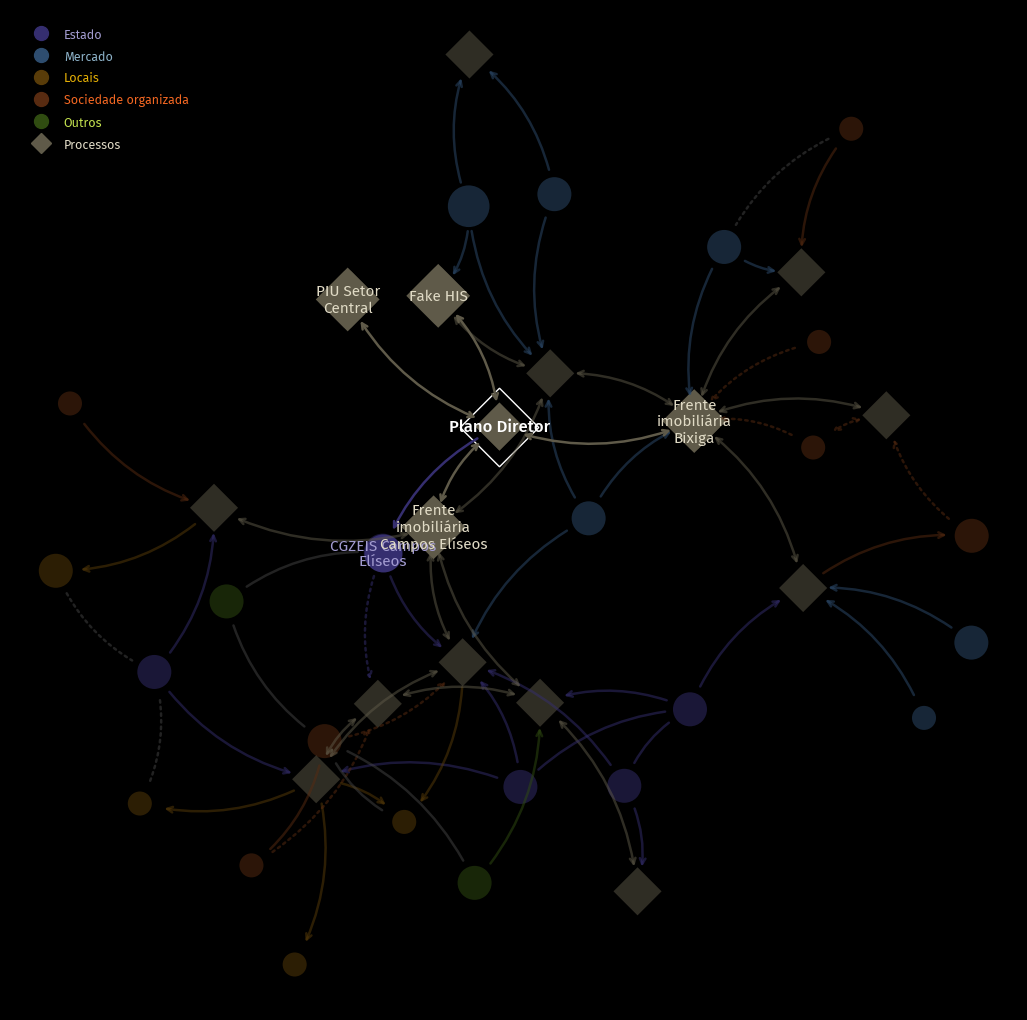

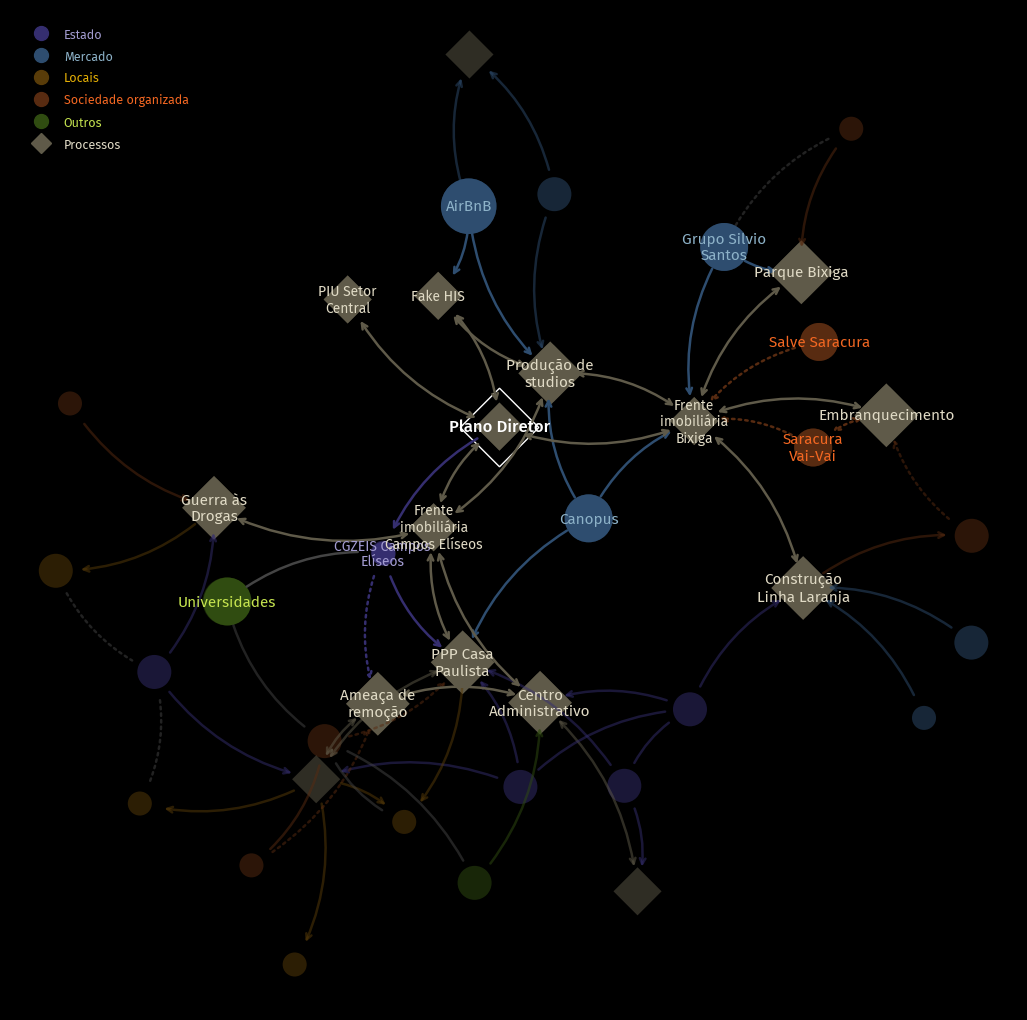

In [ ]:
temas = {
    'pde':['Plano Diretor'],
}

for nome_tema, cards in temas.items():
    for level in [1,2]:
        savename = f'{nome_tema}_n{level}'
        J.plot_subgrafo(ref_nodes=cards,
                        search_dist=[level],
                        figsize=tamanho,
                        savename=savename,
                        savedir=outdir)